In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

plt.style.use('ggplot')


Bad key "text.kerning_factor" on line 4 in
/Users/jamieward/.matplotlib/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 156 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 177 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_csv('1094A.csv', index_col=None)

In [3]:
df.head()

,time,blh,t2m,crr,lsrr,uvb,u10,v10,d2m,pev,...,NO2_pct_anom,hour_number,O3_data,O3_expected,O3_residual,O3_pct_anom,PM2.5_data,PM2.5_expected,PM2.5_residual,PM2.5_pct_anom
0,2015-01-01 08:00:00,30.503819,253.595233,0.0,0.0,0.000000,0.438134,0.644206,245.889635,-7.760101e-07,...,NaN,0,NaN,10.012619,NaN,NaN,NaN,54.654072,NaN,NaN
1,2015-01-01 09:00:00,50.755446,255.820408,0.0,0.0,18165.665221,0.720263,0.781736,247.365563,-2.524582e-06,...,NaN,1,NaN,11.104024,NaN,NaN,NaN,66.484502,NaN,NaN
2,2015-01-01 10:00:00,239.716325,261.780507,0.0,0.0,62852.706436,1.163587,1.674938,247.820755,-2.500688e-05,...,NaN,2,NaN,16.312209,NaN,NaN,NaN,87.107951,NaN,NaN
3,2015-01-01 11:00:00,357.252692,261.317850,0.0,0.0,111279.727163,2.000161,2.432853,247.485147,-5.952067e-05,...,NaN,3,NaN,23.926343,NaN,NaN,NaN,76.203176,NaN,NaN
4,2015-01-01 12:00:00,472.659021,261.192680,0.0,0.0,146885.591929,2.805879,2.834125,247.357875,-9.160825e-05,...,NaN,4,NaN,33.377898,NaN,NaN,NaN,71.227592,NaN,NaN


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
blh,50400.0,585.716407,749.946903,1.217110e+01,53.094928,231.008294,854.046354,4929.904808
t2m,50400.0,279.893605,12.941981,2.452342e+02,269.056716,281.608103,290.854709,307.776909
crr,50400.0,0.000006,0.000061,-4.656613e-10,0.000000,0.000000,0.000000,0.004291
lsrr,50400.0,0.000007,0.000059,-4.656613e-10,0.000000,0.000000,0.000000,0.003786
uvb,50400.0,74717.189037,103585.832500,-1.562500e-02,0.000000,5165.956288,138225.984032,389533.643159
u10,50400.0,0.584603,1.827139,-6.657851e+00,-0.720044,0.322444,1.714213,9.422509
v10,50400.0,-0.167779,2.179539,-9.953152e+00,-1.494962,-0.080784,1.355793,9.781671
d2m,50400.0,268.581836,12.754774,2.357340e+02,257.454910,268.604224,279.739063,294.561741
pev,50400.0,-0.000123,0.000184,-8.513211e-04,-0.000179,-0.000017,-0.000003,0.000012
wdir,50400.0,186.636572,107.855510,4.816765e-04,89.096919,203.063822,276.456133,359.999694


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 26 columns):
time              50400 non-null object
blh               50400 non-null float64
t2m               50400 non-null float64
crr               50400 non-null float64
lsrr              50400 non-null float64
uvb               50400 non-null float64
u10               50400 non-null float64
v10               50400 non-null float64
d2m               50400 non-null float64
pev               50400 non-null float64
wdir              50400 non-null float64
wspd              50400 non-null float64
rh                50400 non-null float64
NO2_data          47713 non-null float64
NO2_expected      50400 non-null float64
NO2_residual      47713 non-null float64
NO2_pct_anom      47713 non-null float64
hour_number       50400 non-null int64
O3_data           46711 non-null float64
O3_expected       50400 non-null float64
O3_residual       46711 non-null float64
O3_pct_anom       46711 non-null 

In [6]:
## Fill the NaNs with interpolated data for O3
## for the sake of this example, I'll keep it simple
df = pd.read_csv('1094A.csv', index_col=None)
df['O3_data'].interpolate(inplace=True)
nulls = df['O3_data'].isnull()
np.where(nulls == True)[0].shape[0]

print(f"The first 17 rows have Nans, so I'm going to remove them!")
df = df.iloc[17:]


The first 17 rows have Nans, so I'm going to remove them!


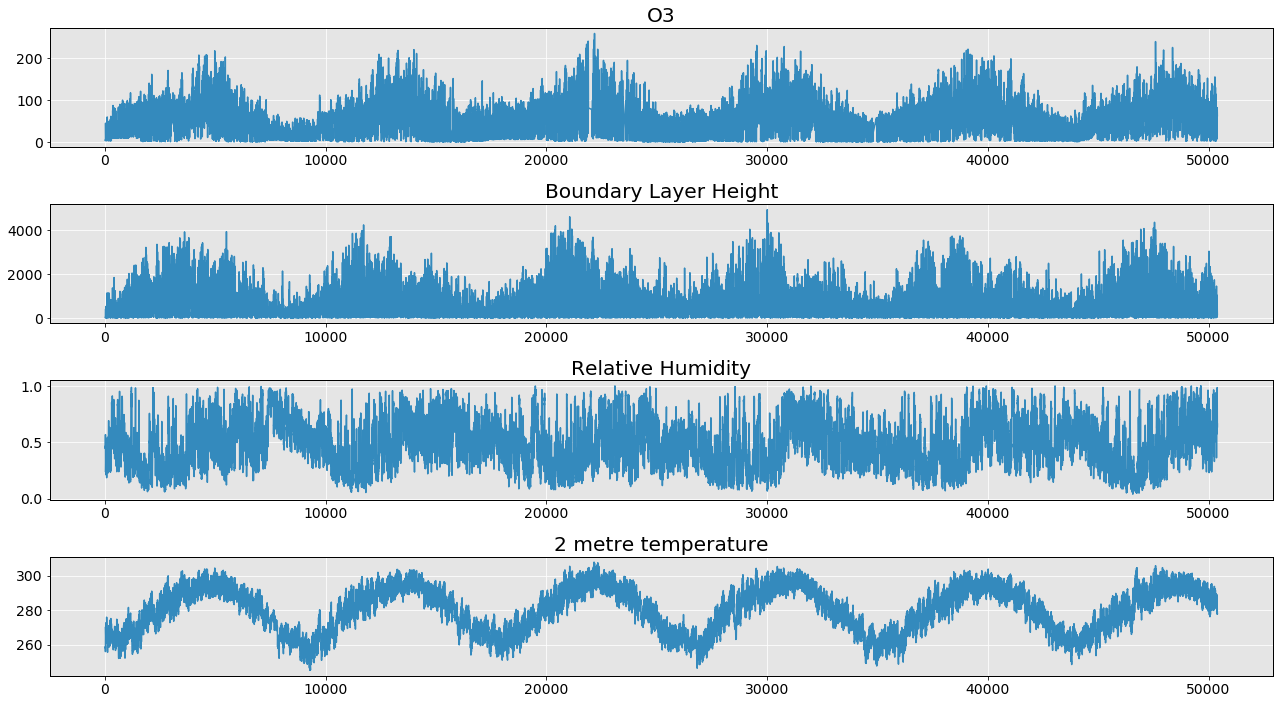

In [7]:
## plot data?

fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(411)
ax.plot(df['O3_data'])
ax.set_title("O3")

ax = fig.add_subplot(412)
ax.plot(df['blh'])
ax.set_title("Boundary Layer Height")

ax = fig.add_subplot(413)
ax.plot(df['rh'])
ax.set_title("Relative Humidity")

ax = fig.add_subplot(414)
ax.plot(df['t2m'])
ax.set_title("2 metre temperature")

plt.tight_layout()
plt.show()

In [8]:
date_time = pd.to_datetime(df.pop('time'), format='%Y-%m-%d %H:%M:%S')


In [9]:
# convert to seconds 
import datetime
timestamp_s = date_time.map(datetime.datetime.timestamp)


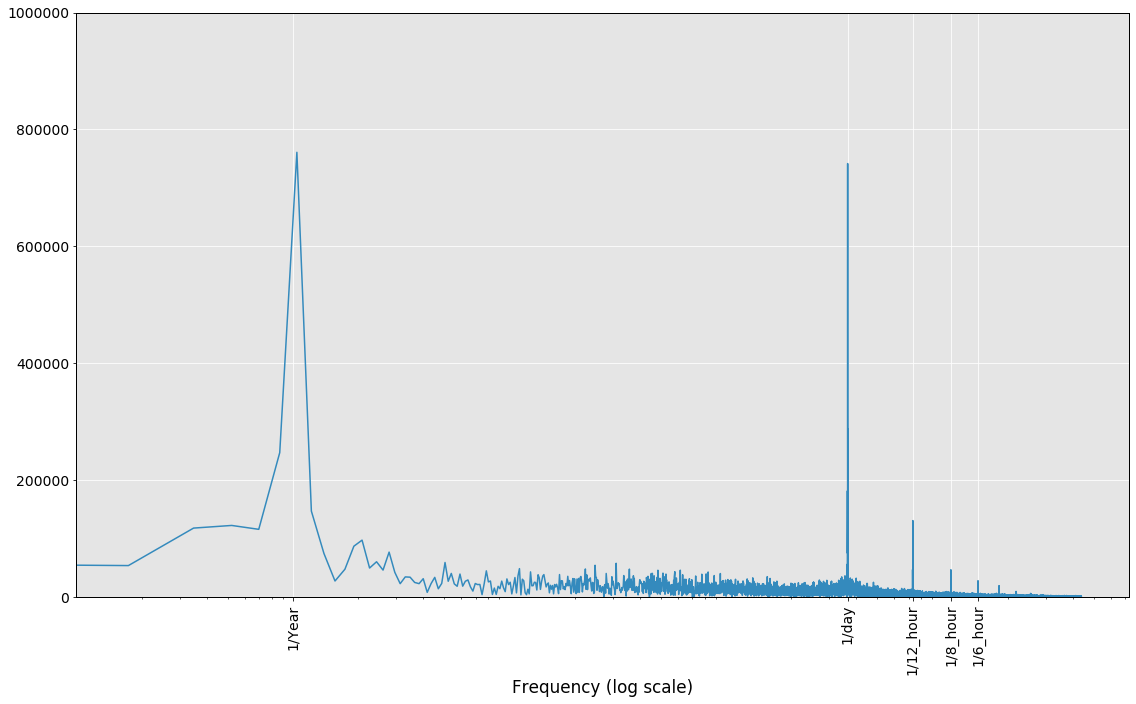

In [10]:
## take fourier transform of some of the data to see 
## if there are any patterns

fft = tf.signal.rfft(df['O3_data'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['O3_data'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset


fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)

ax1.plot(f_per_year, np.abs(fft))
ax1.set_xscale('log')
ax1.set_ylim(0, 1000000)
ax1.set_xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524, 365.2524*2, 365.2524*4, 365.2524*3], 
           labels=['1/Year', '1/day', '1/12_hour', '1/6_hour', '1/8_hour'], 
           rotation=90, horizontalalignment='center')
_ = ax1.set_xlabel('Frequency (log scale)')

plt.tight_layout()

In [11]:
## now also adding 12h and 8h 

day = 24*60*60
year = (365.2425)*day


h12 = 12*60*60
h8 = 8*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df['12h sin'] = np.sin(timestamp_s * (2 * np.pi / h12))
df['12h cos'] = np.cos(timestamp_s * (2 * np.pi / h12))
df['8h sin'] = np.sin(timestamp_s * (2 * np.pi / h8))
df['8h cos'] = np.cos(timestamp_s * (2 * np.pi / h8))






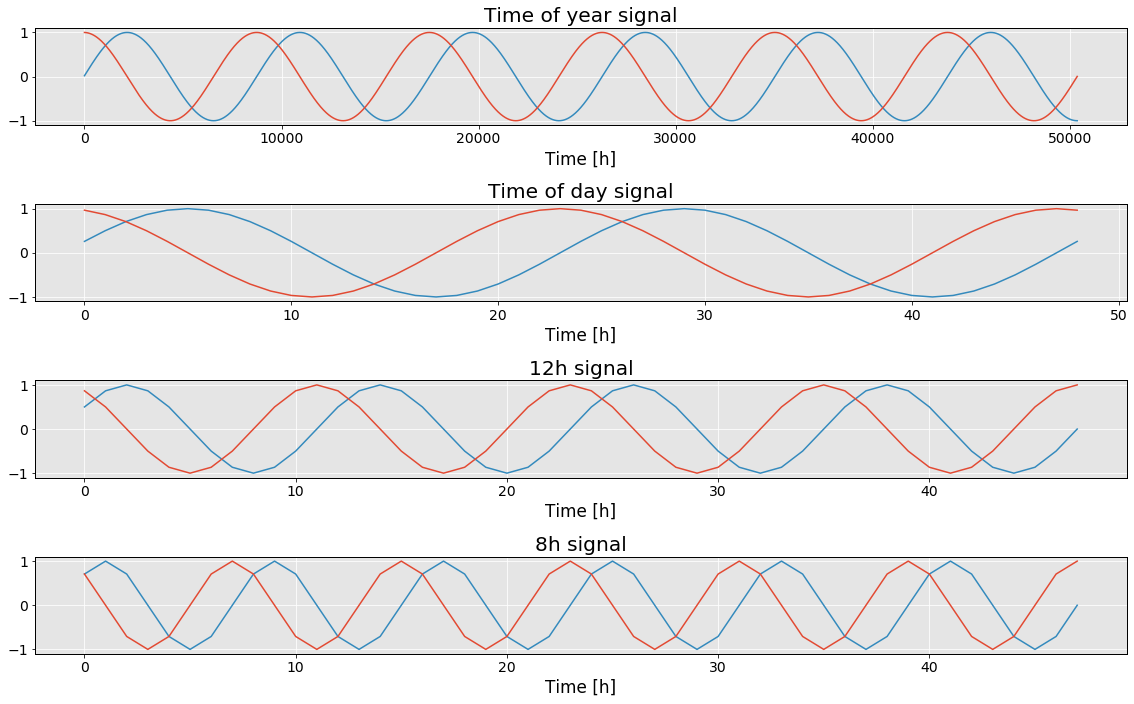

In [12]:
fig = plt.figure(figsize=(16,10))


ax1 = fig.add_subplot(411)
ax1.plot(np.array(df['Year sin'])[:])
ax1.plot(np.array(df['Year cos'])[:])
ax1.set_title('Time of year signal')
ax1.set_xlabel('Time [h]')

ax2 = fig.add_subplot(412)
ax2.plot(np.array(df['Day sin'])[:49])
ax2.plot(np.array(df['Day cos'])[:49])
ax2.set_title('Time of day signal')
ax2.set_xlabel('Time [h]')

ax1 = fig.add_subplot(413)
ax1.plot(np.array(df['12h sin'])[:48])
ax1.plot(np.array(df['12h cos'])[:48])
ax1.set_title('12h signal')
ax1.set_xlabel('Time [h]')

ax2 = fig.add_subplot(414)
ax2.plot(np.array(df['8h sin'])[:48])
ax2.plot(np.array(df['8h cos'])[:48])
ax2.set_title('8h signal')
ax2.set_xlabel('Time [h]')



plt.tight_layout()

In [13]:
## split the data into training and test data sets
ax.plot(df['O3_data'])
ax.plot(df['blh'])
ax.plot(df['rh'])
ax.plot(df['t2m'])

ax1.plot(np.array(df['Year sin'])[:])
ax1.plot(np.array(df['Year cos'])[:])

ax2.plot(np.array(df['Day sin'])[:49])
ax2.plot(np.array(df['Day cos'])[:49])

ax1.plot(np.array(df['12h sin'])[:48])
ax1.plot(np.array(df['12h cos'])[:48])

ax2.plot(np.array(df['8h sin'])[:48])
ax2.plot(np.array(df['8h cos'])[:48])

X = df[['blh', 'rh', 't2m', 'Year sin','Year cos','Day sin','Day cos',
        '12h sin','12h cos','8h sin','8h cos', 'O3_data']].copy()
# Y = df['O3_data'].copy()

In [14]:
# 2019 
test_time = date_time[-15344:-6583]
X_test = X[-15344:-6583]
# Y_test = Y[-15344:-6583]

# 2015 - 2018
train_time = date_time[:26280]
X_train = X[:26280]
# Y_train = X[:26280]

# 2018-2019
valid_time = date_time[26280:-15344]
X_valid = X[26280:-15344]
# Y_valid = X[26280:-15344]

# 2020
covid_time = date_time[-6583:]
X_covid = X[-6583:]
# Y_covid = X[-6583:]

In [15]:
X_train

,blh,rh,t2m,Year sin,Year cos,Day sin,Day cos,12h sin,12h cos,8h sin,8h cos,O3_data
17,35.400952,0.462863,258.355935,0.019424,0.999811,2.588190e-01,0.965926,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01,4.580537
18,30.308304,0.458157,258.445776,0.020140,0.999797,5.000000e-01,0.866025,8.660254e-01,5.000000e-01,1.000000e+00,1.507449e-11,4.580537
19,26.579387,0.443242,258.963516,0.020857,0.999782,7.071068e-01,0.707107,1.000000e+00,2.060538e-11,7.071068e-01,-7.071068e-01,3.664430
20,23.782132,0.475352,257.909805,0.021573,0.999767,8.660254e-01,0.500000,8.660254e-01,-5.000000e-01,1.763783e-11,-1.000000e+00,3.664430
21,20.798622,0.482587,257.807603,0.022290,0.999752,9.659258e-01,0.258819,5.000000e-01,-8.660254e-01,-7.071068e-01,-7.071068e-01,3.664430
...,...,...,...,...,...,...,...,...,...,...,...,...
26292,19.356244,0.328450,263.628456,0.003326,0.999994,-8.660254e-01,0.500000,-8.660254e-01,-5.000000e-01,-1.250906e-11,-1.000000e+00,2.748322
26293,16.405355,0.330435,263.443020,0.004043,0.999992,-7.071068e-01,0.707107,-1.000000e+00,-2.216350e-12,-7.071068e-01,-7.071068e-01,1.832215
26294,17.315961,0.364176,262.102226,0.004759,0.999989,-5.000000e-01,0.866025,-8.660254e-01,5.000000e-01,-1.000000e+00,9.945718e-12,2.748322
26295,18.638178,0.402880,260.702900,0.005476,0.999985,-2.588190e-01,0.965926,-5.000000e-01,8.660254e-01,-7.071068e-01,7.071068e-01,0.916107


In [16]:
## Normalise the data 
# only use the training mean and std
# so the model has no hints in the valid and test set
train_mean = X_train.mean()
train_std = X_train.std()

X_train_norm = (X_train - train_mean) / train_std
X_valid_norm = (X_valid - train_mean) / train_std
X_test_norm = (X_test - train_mean) / train_std

In [17]:
Y_train = X_train_norm['O3_data']
Y_valid = X_valid_norm['O3_data']
Y_test = X_test_norm['O3_data']

In [18]:
# convert to tensor dataset
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm.values))
X_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_norm.values))
X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm.values))

X_train_dataset

<TensorSliceDataset shapes: (12,), types: tf.float64>

## Attempt 1 - Predict an hour with previous day of data

In [19]:
# window the data

# sampling rate = 1h
day = 24
year = 365
month = day * 31
week = day * 7
hour = 1

window_length=day

windows_train = X_train_dataset.window(window_length, shift=1, drop_remainder=True)
windows_valid = X_valid_dataset.window(window_length, shift=1, drop_remainder=True)
windows_test = X_test_dataset.window(window_length, shift=1, drop_remainder=True)

In [20]:
windows_train.element_spec

DatasetSpec(TensorSpec(shape=(12,), dtype=tf.float64, name=None), TensorShape([]))

In [21]:
# convert to a flat dataset

windows_train = windows_train.flat_map(lambda window: window.batch(24))
windows_valid = windows_valid.flat_map(lambda window: window.batch(24))
windows_test = windows_test.flat_map(lambda window: window.batch(24))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [22]:
windows_train.element_spec

TensorSpec(shape=(None, 12), dtype=tf.float64, name=None)

In [23]:
# shuffle the windows and make them into batches
batch_size = 64
windows_train = windows_train.shuffle(10000).batch(batch_size)
windows_valid = windows_valid.shuffle(10000).batch(batch_size)
windows_test = windows_test.batch(batch_size)


In [24]:
windows_train = windows_train.map(lambda windows: (windows[:, :-1], windows[:, -1:][:,-1,-1]))
windows_valid = windows_valid.map(lambda windows: (windows[:, :-1], windows[:, -1:][:,-1,-1]))
windows_test = windows_test.map(lambda windows: (windows[:, :-1], windows[:, -1:][:,-1,-1]))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [25]:
for window in windows_train:
    print(window)

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[ 6.64175301e-01, -1.61636560e+00,  5.05339987e-01, ...,
          9.99980974e-01,  9.99980974e-01,  9.72900527e-01],
        [ 9.48753890e-01, -1.59920917e+00,  5.10599688e-01, ...,
          1.41418666e+00,  3.58307110e-11,  1.03621692e+00],
        [ 1.21140191e+00, -1.56287524e+00,  5.10163178e-01, ...,
          9.99980974e-01, -9.99980974e-01,  1.01511146e+00],
        ...,
        [-6.96169972e-01, -1.33665221e+00, -1.16357786e-01, ...,
         -9.99980974e-01, -9.99980974e-01, -9.26591377e-01],
        [-6.68884758e-01, -1.33610698e+00,  1.05291249e-02, ...,
         -1.41418666e+00,  1.02657174e-11, -3.98954737e-01],
        [-5.45864638e-01, -1.38557383e+00,  7.31913321e-02, ...,
         -9.99980974e-01,  9.99980974e-01, -1.45689150e-01]],

       [[ 2.13777772e+00, -9.32366108e-01,  1.14873277e+00, ...,
          9.99980974e-01, -9.99980974e-01, -1.20096243e+00],
        [ 2.39529174e+00, -1.36174924e+00,  1.34

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-6.66745664e-01, -1.00569609e+00,  3.43154059e-01, ...,
          9.99980974e-01, -9.99980974e-01, -1.11654057e+00],
        [-6.82283980e-01, -1.03036629e+00,  3.46451940e-01, ...,
         -3.86404203e-11, -1.41418666e+00, -1.22206790e+00],
        [-6.99929181e-01, -1.22286408e+00,  4.73043562e-01, ...,
         -9.99980974e-01, -9.99980974e-01, -1.05322417e+00],
        ...,
        [-7.23464977e-01,  9.93170381e-02,  1.17416365e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -2.82874676e-01],
        [-7.36515521e-01,  2.47836117e-01,  3.73231805e-02, ...,
          2.38430254e-12,  1.41418666e+00, -7.15536721e-01],
        [-7.44204646e-01,  1.61186228e-01,  8.92267650e-02, ...,
          9.99980974e-01,  9.99980974e-01, -7.47194919e-01]],

       [[ 1.43289527e-02,  2.02547948e-01, -1.72190952e+00, ...,
         -1.41418666e+00, -2.54205543e-11, -1.90563562e-02],
        [-6.51556705e-02,  2.12862127e-01, -1.72

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-6.89354275e-01, -1.71644117e+00,  5.71010543e-01, ...,
          9.99980974e-01, -9.99980974e-01,  4.45263887e-01],
        [-7.28222846e-01, -1.69295693e+00,  5.08472606e-01, ...,
         -4.95541070e-12, -1.41418666e+00,  6.53655062e-02],
        [-7.44662923e-01, -1.35431050e+00,  2.24413899e-01, ...,
         -9.99980974e-01, -9.99980974e-01, -7.57747652e-01],
        ...,
        [ 2.74035341e+00, -1.78287867e+00,  1.24936569e+00, ...,
         -9.99980974e-01,  9.99980974e-01,  1.01511146e+00],
        [ 2.96471875e+00, -1.79046940e+00,  1.26422309e+00, ...,
         -3.13007071e-11,  1.41418666e+00,  1.07842785e+00],
        [ 2.67455012e+00, -1.64232895e+00,  1.10722901e+00, ...,
          9.99980974e-01,  9.99980974e-01,  1.05732239e+00]],

       [[-7.49539758e-01,  5.96065936e-01, -2.62029135e-01, ...,
          3.85224969e-11,  1.41418666e+00, -6.10009393e-01],
        [-7.54141973e-01,  7.50752911e-01, -3.24

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-7.05486907e-01, -1.04024226e+00,  3.53068558e-01, ...,
         -2.36939423e-11, -1.41418666e+00,  7.33705250e-01],
        [-7.12371798e-01, -8.33937227e-01,  1.71356646e-01, ...,
         -9.99980974e-01, -9.99980974e-01,  6.98529474e-01],
        [-7.13952918e-01, -6.17287757e-01,  5.74925248e-02, ...,
         -1.41418666e+00,  2.00812728e-11,  6.63353698e-01],
        ...,
        [ 1.82243609e+00, -1.48397350e+00,  8.40837709e-01, ...,
         -1.25621755e-11,  1.41418666e+00,  7.61845871e-01],
        [ 1.24461970e+00, -1.34045315e+00,  6.17931159e-01, ...,
          9.99980974e-01,  9.99980974e-01,  6.98529474e-01],
        [-1.71056161e-01, -1.33671826e+00,  6.08022569e-01, ...,
          1.41418666e+00,  1.61996001e-11,  7.19634940e-01]],

       [[ 1.18754575e+00, -3.95796498e-01, -9.93833044e-01, ...,
         -9.99980974e-01,  9.99980974e-01,  4.03052956e-01],
        [ 1.14569407e+00, -4.69076224e-01, -9.76

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[ 7.33065351e-01,  2.46173699e-01,  1.14940835e+00, ...,
         -3.41803405e-11, -1.41418666e+00,  1.12063879e+00],
        [ 9.44048926e-01,  1.45225584e-01,  1.15289132e+00, ...,
         -9.99980974e-01, -9.99980974e-01,  1.31058798e+00],
        [ 1.05408029e+00,  6.95906502e-02,  1.15661586e+00, ...,
         -1.41418666e+00,  3.05676710e-11,  1.62716996e+00],
        ...,
        [-1.63839593e-01,  1.13021113e+00,  8.52748592e-01, ...,
         -2.07577729e-12,  1.41418666e+00,  8.88478664e-01],
        [ 3.14977953e-01,  2.42826020e-01,  1.16113512e+00, ...,
          9.99980974e-01,  9.99980974e-01,  1.18395518e+00],
        [ 7.56685509e-01,  1.61928608e-01,  1.17627770e+00, ...,
          1.41418666e+00,  5.71320194e-12,  1.28948251e+00]],

       [[-7.13952918e-01, -6.17287757e-01,  5.74925248e-02, ...,
         -1.41418666e+00,  2.00812728e-11,  6.63353698e-01],
        [-7.18462672e-01, -4.94672479e-01,  3.15

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-6.59985534e-01, -1.57815853e+00, -7.17981466e-02, ...,
          9.99980974e-01, -9.99980974e-01, -7.78853118e-01],
        [-7.07817319e-01, -1.77054526e+00,  4.20676091e-02, ...,
         -2.43619685e-11, -1.41418666e+00, -1.11654057e+00],
        [-7.24295301e-01, -1.81530042e+00,  7.38789052e-02, ...,
         -9.99980974e-01, -9.99980974e-01, -1.17985696e+00],
        ...,
        [ 2.27261392e+00, -1.86498817e+00,  4.89144956e-01, ...,
         -9.99980974e-01,  9.99980974e-01,  1.35279891e+00],
        [ 2.10611830e+00, -1.96544422e+00,  4.47563313e-01, ...,
         -1.18941493e-11,  1.41418666e+00,  1.20506065e+00],
        [ 1.78882992e+00, -2.01912967e+00,  4.31609331e-01, ...,
          9.99980974e-01,  9.99980974e-01,  8.88478664e-01]],

       [[-7.08636593e-01,  1.61146421e+00, -2.23033490e-01, ...,
          9.99980974e-01, -9.99980974e-01, -9.63525942e-01],
        [-7.23683430e-01,  1.59900653e+00, -2.29

        1.14174425e+00, -6.94431255e-01, -5.88903927e-01,  2.04910942e-03])>)
(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-7.00510785e-01,  6.52394419e-01, -1.10244350e+00, ...,
          3.04977331e-11,  1.41418666e+00, -1.11654057e+00],
        [-6.81714207e-01,  6.48075947e-01, -1.11463712e+00, ...,
          9.99980974e-01,  9.99980974e-01, -1.22206790e+00],
        [-6.45204722e-01,  7.46509462e-01, -1.15769402e+00, ...,
          1.41418666e+00, -2.68603084e-11, -1.20096243e+00],
        ...,
        [-6.47558723e-01,  6.08187371e-01, -1.08246877e+00, ...,
          5.74709098e-12, -1.41418666e+00, -1.87900081e-01],
        [-6.24320955e-01,  6.38366088e-01, -1.12986751e+00, ...,
         -9.99980974e-01, -9.99980974e-01, -2.51216478e-01],
        [-5.99577441e-01,  7.44538930e-01, -1.24919664e+00, ...,
         -1.41418666e+00, -9.35976051e-12, -1.03478219e-01]],

       [[ 2.52039272e+00, -1.67061218e+00,  5.68835205e-01, ...,
          3.29537343e-11,  1.41

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-6.27566231e-03,  1.78208151e+00, -9.34890743e-01, ...,
          9.99980974e-01,  9.99980974e-01,  1.07576437e-01],
        [-3.16244216e-01,  2.05774480e+00, -1.00095433e+00, ...,
          1.41418666e+00,  1.68704428e-11,  2.31545750e-02],
        [-3.29521028e-01,  2.21604383e+00, -9.73117533e-01, ...,
          9.99980974e-01, -9.99980974e-01,  8.64709718e-02],
        ...,
        [ 2.44688772e+00, -2.40024328e-01, -8.13052718e-01, ...,
         -9.99980974e-01, -9.99980974e-01,  5.29685749e-01],
        [ 2.45235936e+00, -2.10947482e-01, -8.13434031e-01, ...,
         -1.41418666e+00,  2.92259856e-11,  6.98529474e-01],
        [ 2.24587346e+00, -2.44133330e-01, -8.04531861e-01, ...,
         -9.99980974e-01,  9.99980974e-01,  7.61845871e-01]],

       [[ 5.47162939e-01,  4.51374256e-01,  1.52432367e+00, ...,
          9.99980974e-01,  9.99980974e-01,  2.87239243e+00],
        [-5.32681093e-01,  6.14077053e-01,  1.50

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[ 6.48681897e-01,  2.57655799e-01,  8.32107667e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -2.93427409e-01],
        [ 5.64272298e-01,  2.33314729e-01,  8.34877665e-01, ...,
          2.83904175e-12,  1.41418666e+00, -1.24583684e-01],
        [ 3.14509023e-01,  5.49713214e-01,  6.33078506e-01, ...,
          9.99980974e-01,  9.99980974e-01, -1.03478219e-01],
        ...,
        [ 5.89671588e-01,  1.48663779e+00, -1.35405980e-02, ...,
          9.99980974e-01, -9.99980974e-01,  3.18631093e-01],
        [ 1.03580515e+00,  6.33350806e-01,  2.11430138e-01, ...,
          3.34057823e-11, -1.41418666e+00,  2.13103765e-01],
        [ 1.42344690e+00,  2.58965358e-01,  3.19505951e-01, ...,
         -9.99980974e-01, -9.99980974e-01,  4.45263887e-01]],

       [[ 8.54407014e-01, -1.16241700e-01, -5.30291018e-01, ...,
          1.53324603e-11, -1.41418666e+00,  2.13103765e-01],
        [ 8.84642070e-01, -6.02223191e-01, -4.10

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-7.31492113e-01,  6.67396169e-01, -1.34309847e-01, ...,
          9.99980974e-01, -9.99980974e-01,  2.04910942e-03],
        [-7.41793780e-01,  6.66731907e-01, -1.58764715e-01, ...,
         -1.05354394e-11, -1.41418666e+00, -2.72321943e-01],
        [-7.44393086e-01,  3.69989107e-01, -6.21183297e-02, ...,
         -9.99980974e-01, -9.99980974e-01, -7.15536721e-01],
        ...,
        [-7.38177605e-01, -4.80351154e-01,  1.69951139e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -1.24317336e+00],
        [-7.44421679e-01, -3.11508938e-01,  7.34589926e-02, ...,
         -2.57206784e-11,  1.41418666e+00, -1.22206790e+00],
        [-7.47377946e-01, -2.62629042e-01,  5.65184804e-02, ...,
          9.99980974e-01,  9.99980974e-01, -1.24317336e+00]],

       [[-3.51859734e-01,  2.00700517e+00,  3.31579343e-01, ...,
          1.28905417e-11, -1.41418666e+00,  1.35013543e-01],
        [-9.20109156e-02,  2.02644064e+00,  2.93

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-7.29376414e-01, -2.91580582e-01, -7.81659539e-01, ...,
         -1.41418666e+00, -1.20290488e-11, -1.17985696e+00],
        [-7.38385123e-01, -1.18923600e-01, -8.63838366e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -1.17985696e+00],
        [-7.46407514e-01, -1.05388053e-01, -8.54302874e-01, ...,
         -1.56721203e-11,  1.41418666e+00, -1.15875150e+00],
        ...,
        [-7.44309484e-01, -5.06619471e-02, -7.75698439e-01, ...,
          1.41418666e+00, -3.40065756e-11, -1.13764603e+00],
        [-7.42043233e-01,  3.39939912e-02, -8.33735914e-01, ...,
          9.99980974e-01, -9.99980974e-01, -1.17985696e+00],
        [-7.33057433e-01,  1.19380996e-01, -8.59215724e-01, ...,
         -3.03995530e-11, -1.41418666e+00, -1.17985696e+00]],

       [[-7.49091429e-01,  4.62026683e-01, -5.44283973e-01, ...,
          1.41418666e+00,  9.94591217e-12, -1.17985696e+00],
        [-7.39333163e-01,  6.80147596e-01, -6.19

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-3.53510194e-01, -1.07524029e+00,  1.32336066e+00, ...,
          3.58589670e-11, -1.41418666e+00,  6.56318543e-01],
        [-4.09285849e-01, -9.35752325e-01,  1.21454703e+00, ...,
         -9.99980974e-01, -9.99980974e-01,  5.29685749e-01],
        [-2.87514815e-01, -7.69350769e-01,  1.06988739e+00, ...,
         -1.41418666e+00,  4.28448608e-11,  9.72900527e-01],
        ...,
        [ 2.50644937e+00, -1.17241839e+00,  1.29950195e+00, ...,
          1.02014125e-11,  1.41418666e+00,  8.04056802e-01],
        [ 2.35009520e+00, -9.86278173e-01,  1.10408026e+00, ...,
          9.99980974e-01,  9.99980974e-01,  7.82951337e-01],
        [ 1.72185908e+00, -9.59767941e-01,  1.09186504e+00, ...,
          1.41418666e+00, -6.56398782e-12,  8.04056802e-01]],

       [[-7.36728390e-01,  1.96659532e+00, -7.07493157e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -1.15875150e+00],
        [-7.36692296e-01,  1.90123415e+00, -7.34

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-7.18222784e-01, -4.86455833e-02, -6.65837891e-01, ...,
          3.72005272e-11,  1.41418666e+00, -1.07432964e+00],
        [-7.21212084e-01, -2.65187695e-02, -6.55995284e-01, ...,
          9.99980974e-01,  9.99980974e-01, -1.09543510e+00],
        [-7.24341928e-01,  3.17397021e-02, -6.75005192e-01, ...,
          1.41418666e+00, -3.35631025e-11, -1.09543510e+00],
        ...,
        [-7.09270336e-01, -7.24378084e-01, -9.97478711e-02, ...,
         -9.55703125e-13, -1.41418666e+00, -3.98954737e-01],
        [-7.23650651e-01, -2.77898497e-01, -3.46491115e-01, ...,
         -9.99980974e-01, -9.99980974e-01, -5.04482065e-01],
        [-7.38208625e-01, -3.69771238e-01, -2.76305762e-01, ...,
         -1.41418666e+00, -2.65696640e-12, -1.05322417e+00]],

       [[-7.54563867e-01,  1.60435758e+00, -1.02742754e+00, ...,
          9.99980974e-01, -9.99980974e-01, -1.17985696e+00],
        [-7.56387648e-01,  1.65777175e+00, -1.02

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-6.86639295e-01,  7.84369707e-02, -8.38752361e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -1.17985696e+00],
        [-6.80538316e-01,  1.63732906e-01, -8.27915789e-01, ...,
          2.62012172e-12,  1.41418666e+00, -1.15875150e+00],
        [-6.28607633e-01,  1.89589492e-01, -7.98824140e-01, ...,
          9.99980974e-01,  9.99980974e-01, -1.13764603e+00],
        ...,
        [-6.52084383e-02,  1.30301197e-01, -1.35070226e+00, ...,
          9.99980974e-01, -9.99980974e-01,  4.66369353e-01],
        [-7.67315664e-02, -1.78985061e-01, -1.49643749e+00, ...,
          3.36247023e-11, -1.41418666e+00,  4.66369353e-01],
        [-4.69996500e-02, -2.42855606e-01, -1.51100456e+00, ...,
         -9.99980974e-01, -9.99980974e-01,  5.50791215e-01]],

       [[ 1.64741912e-01,  1.74877835e-01,  1.31025661e+00, ...,
         -1.74516458e-11,  1.41418666e+00,  4.03052956e-01],
        [ 6.61109837e-01, -3.33559987e-01,  1.63

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-4.93140745e-01,  3.75103452e-01,  1.43766535e+00, ...,
         -1.41418666e+00,  2.54536476e-11, -1.24583684e-01],
        [-5.46555777e-01,  4.76854880e-01,  1.38380207e+00, ...,
         -9.99980974e-01,  9.99980974e-01,  3.81947490e-01],
        [-5.83065134e-01,  7.37535230e-01,  1.27455155e+00, ...,
          2.18105761e-11,  1.41418666e+00,  2.34209231e-01],
        ...,
        [-1.20294641e-01,  9.53733727e-01,  1.36739292e+00, ...,
          1.41418666e+00,  1.08272253e-11,  1.50053717e+00],
        [-3.93566876e-01,  1.22286791e+00,  1.32005509e+00, ...,
          9.99980974e-01, -9.99980974e-01,  1.37390437e+00],
        [-6.71246874e-01,  1.21311044e+00,  1.33865997e+00, ...,
          1.44342480e-11, -1.41418666e+00,  9.51795061e-01]],

       [[-6.38081241e-01,  2.12578212e-01, -1.24737951e+00, ...,
          1.41418666e+00,  1.10545949e-11, -9.89907774e-01],
        [-3.11691211e-01,  2.03691368e-01, -1.21

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-7.47227165e-01,  3.74600802e-01, -8.99029206e-01, ...,
         -1.41418666e+00,  2.36713056e-11, -1.17985696e+00],
        [-7.48449893e-01,  3.94236274e-01, -9.07452943e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -1.17985696e+00],
        [-7.31136721e-01,  4.03141640e-01, -8.61751154e-01, ...,
          2.00282340e-11,  1.41418666e+00, -1.17985696e+00],
        ...,
        [-7.25976667e-01,  9.03147215e-01, -5.27744751e-01, ...,
          1.41418666e+00,  1.26095674e-11, -1.20096243e+00],
        [-7.30835745e-01,  9.56289128e-01, -5.34303669e-01, ...,
          9.99980974e-01, -9.99980974e-01, -1.20096243e+00],
        [-7.29595080e-01,  1.17012663e+00, -5.82332589e-01, ...,
          1.62165900e-11, -1.41418666e+00, -1.20096243e+00]],

       [[ 3.34306335e+00, -1.85039073e+00,  1.16935860e+00, ...,
         -9.99980974e-01,  9.99980974e-01,  9.94005992e-01],
        [ 2.82668577e+00, -1.83290240e+00,  1.13

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-6.68450636e-01,  8.67356331e-01,  8.36323904e-01, ...,
          1.41418666e+00,  3.00120466e-11, -4.62271134e-01],
        [-6.62898954e-01,  9.18872392e-01,  7.93900037e-01, ...,
          9.99980974e-01, -9.99980974e-01, -9.26591377e-01],
        [-6.49939358e-01,  8.44200663e-01,  8.14293361e-01, ...,
          3.36190693e-11, -1.41418666e+00, -6.10009393e-01],
        ...,
        [-6.27168061e-01,  1.82327496e+00,  1.01032224e+00, ...,
         -1.41418666e+00,  1.60843818e-11, -4.41165668e-01],
        [-6.15261426e-01,  1.85762095e+00,  1.01176584e+00, ...,
         -9.99980974e-01,  9.99980974e-01, -8.42169514e-01],
        [-5.57701813e-01,  1.94497949e+00,  9.78074205e-01, ...,
          1.24413102e-11,  1.41418666e+00, -8.63274980e-01]],

       [[-7.28574626e-01, -3.48949556e-01,  1.23801619e+00, ...,
         -9.99980974e-01, -9.99980974e-01,  8.88478664e-01],
        [-7.10717154e-01, -5.23351889e-02,  1.10

        1.07576437e-01, -1.09543510e+00,  9.94005992e-01,  7.40740405e-01])>)
(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[ 8.37186316e-01, -2.15892595e-02,  1.36090268e+00, ...,
          1.41418666e+00, -1.57199667e-11,  1.22616611e+00],
        [ 1.54200053e+00, -3.35068610e-01,  1.41121379e+00, ...,
          9.99980974e-01, -9.99980974e-01,  1.73269729e+00],
        [ 1.88693960e+00, -1.04540307e+00,  1.61781694e+00, ...,
         -1.21129440e-11, -1.41418666e+00,  1.81711915e+00],
        ...,
        [-6.61819193e-01, -9.92299437e-02,  9.75640183e-01, ...,
         -1.41418666e+00, -2.05001023e-11, -5.04482065e-01],
        [-6.01845937e-01,  1.69038906e-01,  9.54380931e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -6.10009393e-01],
        [-4.17502701e-01,  5.73346621e-01,  9.05087345e-01, ...,
         -2.41431738e-11,  1.41418666e+00, -5.78351195e-01]],

       [[-7.47340239e-01,  7.46776106e-01, -3.20350433e-01, ...,
         -1.41418666e+00, -2.58

       -0.27232194, -1.1587515 ,  0.23420923,  4.0542985 ])>)
(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-1.76579901e-01,  1.15891706e+00, -2.45490626e-01, ...,
         -1.41418666e+00, -3.30074782e-11, -5.04482065e-01],
        [-1.10156594e-01,  1.16260643e+00, -2.45009463e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -5.88903927e-01],
        [-2.73236437e-01,  1.20027300e+00, -2.84650132e-01, ...,
         -3.66505497e-11,  1.41418666e+00, -5.46692996e-01],
        ...,
        [-6.46419558e-01,  1.46220193e+00, -4.20418202e-01, ...,
          1.41418666e+00, -1.30281462e-11, -9.26591377e-01],
        [-5.76872097e-01,  1.63599396e+00, -4.24930787e-01, ...,
          9.99980974e-01, -9.99980974e-01, -1.01101324e+00],
        [-3.85188485e-01,  1.79673156e+00, -4.38151502e-01, ...,
         -9.42112358e-12, -1.41418666e+00, -7.57747652e-01]],

       [[-2.20960391e-02, -1.14704553e+00, -1.10060189e+00, ...,
         -2.48307904e-11, -1.41418666e+00, -5.6

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[-1.36985940e-01,  1.14345451e-01,  1.53341297e+00, ...,
         -9.99980974e-01,  9.99980974e-01, -1.90563562e-02],
        [ 2.35418314e-01,  1.49022805e-01,  1.55961142e+00, ...,
          1.19950206e-11,  1.41418666e+00,  5.93002146e-01],
        [ 7.65379430e-01, -1.68896462e-01,  1.72378040e+00, ...,
          9.99980974e-01,  9.99980974e-01,  1.01511146e+00],
        ...,
        [-3.54271559e-01,  6.40008925e-01,  1.07923916e+00, ...,
          9.99980974e-01, -9.99980974e-01, -5.88903927e-01],
        [-4.05799697e-01,  5.87320285e-01,  1.08135433e+00, ...,
          2.42498034e-11, -1.41418666e+00, -9.05485911e-01],
        [-4.05285630e-01,  1.51735167e-01,  1.26217226e+00, ...,
         -9.99980974e-01, -9.99980974e-01, -2.72321943e-01]],

       [[-7.35311304e-01, -7.99482639e-01, -8.78638795e-01, ...,
          2.65009673e-11, -1.41418666e+00, -4.20060203e-01],
        [-7.47430010e-01, -7.36537154e-01, -9.35

(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[ 2.82106549e-01,  9.85898765e-01, -8.79135718e-01, ...,
         -9.99980974e-01, -9.99980974e-01, -8.23727530e-02],
        [ 6.20749623e-02,  9.96115378e-01, -9.24454741e-01, ...,
         -1.41418666e+00,  3.90640732e-11, -4.01618218e-02],
        [ 9.83588623e-03,  1.02751716e+00, -9.28309544e-01, ...,
         -9.99980974e-01,  9.99980974e-01, -1.90563562e-02],
        ...,
        [-6.94101837e-01,  6.03786203e-01, -1.04263746e+00, ...,
          9.99980974e-01,  9.99980974e-01, -1.17985696e+00],
        [-6.95081343e-01,  6.43535863e-01, -1.08068031e+00, ...,
          1.41418666e+00, -2.78320028e-12, -1.20096243e+00],
        [-6.95514334e-01,  7.91066962e-01, -1.12618131e+00, ...,
          9.99980974e-01, -9.99980974e-01, -1.22206790e+00]],

       [[-6.87827830e-01, -1.16498492e+00,  3.03746598e-01, ...,
          1.41418666e+00, -1.99554934e-11,  1.14174425e+00],
        [-7.36651533e-01, -1.21246786e+00,  3.25

In [26]:
## Baseline metric tests
model = keras.models.Sequential([
    keras.layers.Dense(20),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20), 
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

# drop the target label
train_use = X_train_norm.drop(columns=['O3_data'])
valid_use = X_valid_norm.drop(columns=['O3_data'])
test_use = X_test_norm.drop(columns=['O3_data'])


model.compile(loss=keras.losses.mean_squared_error, optimizer="adam")

history = model.fit(train_use, Y_train, validation_data=(valid_use, Y_valid), epochs=20)


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor

In [27]:
## calculate R^2 score for Ben
from sklearn.metrics import r2_score

y_pred = model.predict(test_use)

print(r2_score(Y_test, y_pred))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.6330860412050465


In [28]:
model_rnn = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 12],
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.LSTM(20, return_sequences=False,
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.Dense(1)
])

model_rnn.compile(loss=keras.losses.mean_squared_error, optimizer="adam")

history = model_rnn.fit(windows_train, validation_data=windows_valid, epochs=20)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    411/Unknown - 21s 51ms/step - loss: 0.2364WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x151b67cb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'argumen

In [29]:
# get Y-true from the input datasets

y_true_test_rnn = []

count=0
for X,Y in windows_test:
    count += 1
    y_true_test_rnn.extend(list(Y.numpy()))
y_true_test_rnn = np.array(y_true_test_rnn)
    
y_pred = model_rnn.predict(windows_test)

print(y_pred.shape)
print(y_true_test_rnn.shape)

print(r2_score(y_true_test_rnn, y_pred.flatten()))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(8738, 1)
(8738,)
0.93081210823507


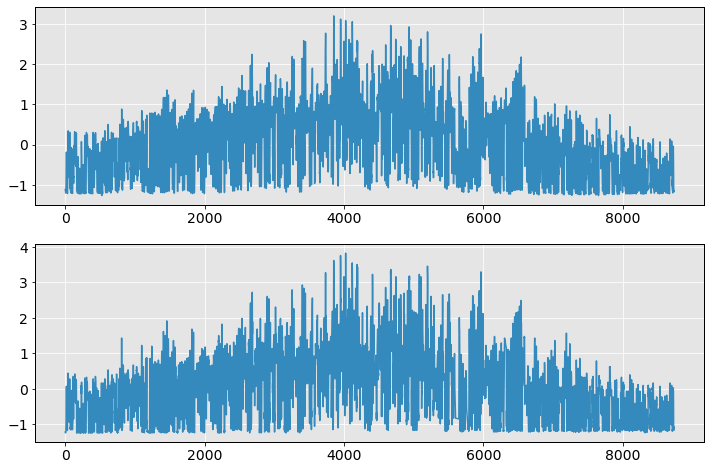

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
ax.plot(y_pred)
ax = fig.add_subplot(212)
ax.plot(y_true_test_rnn)

## Attempt 2 - Predict a day given the past week

- First using an RNN using the last hidden state of the previous time step. 
- Then using a sequence to sequence RNN. 
    - Note: Tried this but currently does not work as the labels are not time distributed. I am going to move on to other things and I dont want to spend time bogged down in trying to get the labels in the right format. 
    - Currently, the previous RNN works very well which is good enough for me :). 

In [31]:
day = 24
year = 365
month = day * 31
week = day * 7
hour = 1

window_length=day + week

windows_train_week = X_train_dataset.window(window_length, shift=day, drop_remainder=True)
windows_valid_week = X_valid_dataset.window(window_length, shift=day, drop_remainder=True)
windows_test_week = X_test_dataset.window(window_length, shift=day, drop_remainder=True)

In [32]:
windows_train_week = windows_train_week.flat_map(lambda window: window.batch(window_length))
windows_valid_week = windows_valid_week.flat_map(lambda window: window.batch(window_length))
windows_test_week = windows_test_week.flat_map(lambda window: window.batch(window_length))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [33]:
# shuffle the windows and make them into batches
batch_size = 64
windows_train_week = windows_train_week.shuffle(10000).batch(batch_size)
windows_valid_week = windows_valid_week.shuffle(10000).batch(batch_size)
windows_test_week = windows_test_week.batch(batch_size)

In [34]:
windows_train_week = windows_train_week.map(lambda windows: (windows[:, :-24, :], windows[:, -24:][:,-24:,-1:]))
windows_valid_week = windows_valid_week.map(lambda windows: (windows[:, :-24, :], windows[:, -24:][:,-24:,-1:]))
windows_test_week = windows_test_week.map(lambda windows: (windows[:, :-24, :], windows[:, -24:][:,-24:,-1:]))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [35]:
for X,Y in windows_train_week:
    print(X)
    print(Y)

tf.Tensor(
[[[-6.86520277e-01  2.11735639e+00  3.98949058e-01 ...  1.91243887e-11
    1.41418666e+00  8.25162268e-01]
  [-6.94913624e-01  2.11680390e+00  3.90917880e-01 ...  9.99980974e-01
    9.99980974e-01  8.46267733e-01]
  [-7.17478856e-01  2.12924847e+00  3.70244617e-01 ...  1.41418666e+00
   -1.54869640e-11  8.88478664e-01]
  ...
  [-7.37037987e-01  1.36232843e+00  8.61564683e-01 ... -9.99980974e-01
   -9.99980974e-01 -5.67798462e-01]
  [-7.41604321e-01  1.66143119e+00  7.38443276e-01 ... -1.41418666e+00
   -3.47870036e-11 -6.73325790e-01]
  [-7.33992704e-01  1.81738296e+00  7.12776006e-01 ... -9.99980974e-01
    9.99980974e-01 -2.09005547e-01]]

 [[-4.18729927e-01 -2.09612287e-01 -9.35574643e-01 ... -4.28750979e-12
    1.41418666e+00 -4.83376599e-01]
  [-5.65065216e-01 -1.70460159e-01 -9.24277502e-01 ...  1.41418666e+00
    7.92493445e-12 -5.88903927e-01]
  [-5.90384128e-01 -1.18765786e-01 -9.25262259e-01 ...  9.99980974e-01
   -9.99980974e-01 -2.09005547e-01]
  ...
  [-7.103638

In [45]:
model_rnn_2 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 12],
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.LSTM(20, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, :, -1], Y_pred[:, :, -1])

model_rnn_2.summary()

model_rnn_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam")

history = model_rnn_2.fit(windows_train_week, validation_data=windows_valid_week, epochs=10)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 20)          2640      
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 20)          3280      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 24)          504       
Total params: 6,424
Trainable params: 6,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the 

InvalidArgumentError:  Incompatible shapes: [64,168,24] vs. [64,24,1]
	 [[node gradient_tape/mean_squared_error/BroadcastGradientArgs (defined at <ipython-input-45-54f78de9c251>:16) ]] [Op:__inference_train_function_83377]

Function call stack:
train_function
